In [1]:
from data.download import download

# Get daily grayscale rainfall data (https://neo.gsfc.nasa.gov/archive/gs/GPM_3IMERGDL/)
imgs_dir = download()

In [2]:
from glob import glob

# Explore with last 10 images
imgs_list = sorted(glob(imgs_dir + '/*.PNG'))[-100:]

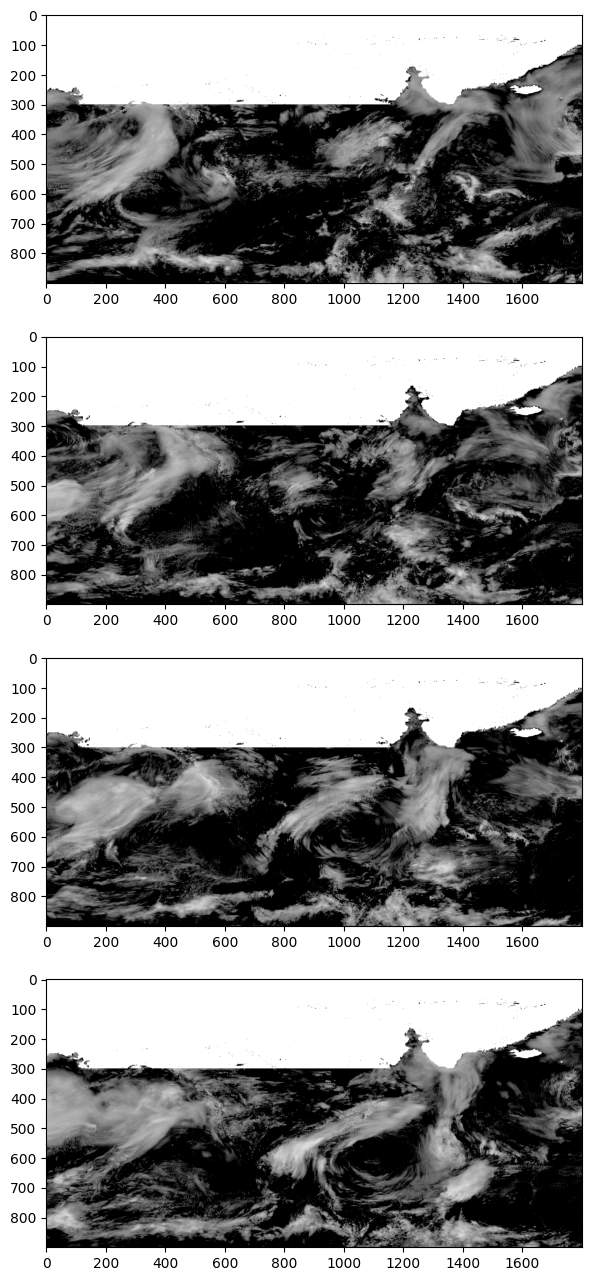

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot last 4 as EDA
limgs = np.array([
                    plt.imread(imgs_list[-i]) for i in [4,3,2,1]
                    ])


fig, axs = plt.subplots(4, 1, figsize=(8, 16))
for i, (img, ax) in enumerate(zip(limgs, axs.flatten())):
    plt.subplot(4, 1, i+1)
    img = img[:img.shape[0]//2, :img.shape[1]//2] # Take North Western quadrant
    plt.imshow(img, cmap='gray')

In [4]:
%%time

# Convert images to array
imgs = np.array([
                    plt.imread(img) for img in imgs_list
                    ])

# Take North West quadrant (crop lattitude at 300 (65\deg I think) as well --> all black predictions)
# Sample geotiff may be best (though inelegant)
original_shape = imgs[0].shape
print(imgs.shape)
imgs = imgs[:, 300:original_shape[0]//2, :original_shape[1]//2]
imgs.shape

(100, 1800, 3600)
CPU times: user 5.17 s, sys: 13 s, total: 18.1 s
Wall time: 21.1 s


(100, 600, 1800)

In [5]:
train = imgs[:80]
test = imgs[80:]

In [6]:
def batch(imgs_arr, seq_len, batch_size):
    """
    seq_len should include the label image
    Note: Lazy load and make individual batches during training/testing
    """
    
    n_batches = len(imgs_arr) // (seq_len * batch_size)
    
    X = np.array([
                    np.array([
                                imgs_arr[
                                    batch_n * batch_size * seq_len + seq_n * seq_len:
                                    batch_n * batch_size * seq_len + seq_n * seq_len + seq_len - 1
                                ].reshape(seq_len - 1, 1, *(imgs_arr.shape[-2:])) # Explicit single gs channel
                                for seq_n in range(batch_size)
                    ])
                    for batch_n in range(n_batches)
                ])
    y = np.array([
                    np.array([
                                imgs_arr[
                                    batch_n * batch_size * seq_len + seq_n * seq_len + seq_len - 1
                                ].reshape(1, *(imgs_arr.shape[-2:])) # Explicit single gs channel
                                for seq_n in range(batch_size)
                    ])
                    for batch_n in range(n_batches)
                ])
    return X, y

In [7]:
%%time

seq_len = 5
batch_size = 1

X_train_batch, y_train_batch = batch(train, seq_len=seq_len, batch_size=batch_size)

X_train_batch.shape, y_train_batch.shape

CPU times: user 195 ms, sys: 111 ms, total: 306 ms
Wall time: 370 ms


((16, 1, 4, 1, 600, 1800), (16, 1, 1, 600, 1800))

In [8]:
import torch
from torch import nn


class ConvRNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernal_size_, padding_, out_size=1):
        super(ConvRNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.conv1 = nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=kernal_size_, padding=padding_)

    def forward(self, in_tensor, h):
        h = torch.cat((in_tensor, h), dim=1)
        h = torch.tanh(self.conv1(h))
        h = torch.tanh(self.conv2(h))
        return self.conv3(h), h

    def init_hidden(self, batch_size, img_size):
        return torch.zeros(batch_size, self.hidden_channels, *img_size)

CPU times: user 29.8 s, sys: 13.4 s, total: 43.1 s
Wall time: 27.4 s


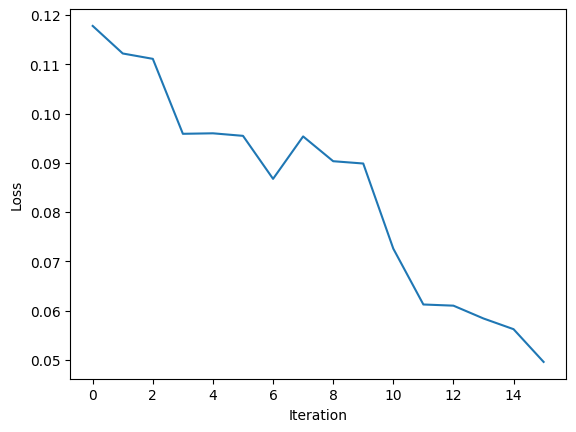

In [9]:
%%time

X_train = torch.from_numpy(X_train_batch)
y_train = torch.from_numpy(y_train_batch)

in_channels = X_train_batch.shape[3]
hidden_channels = 2

model = ConvRNN(in_channels, hidden_channels, kernal_size_=3, padding_=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
train_losses = []

for X_batch, y_batch in zip(X_train, y_train):

    hidden = model.init_hidden(batch_size, X_batch.shape[-2:])
    for step in range(seq_len - 1 - 1):
        _, hidden = model(X_batch[:,step], hidden)

    y_pred, _ = model(X_batch[:, -1], hidden)
    loss = criterion(y_pred, y_batch)
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss");

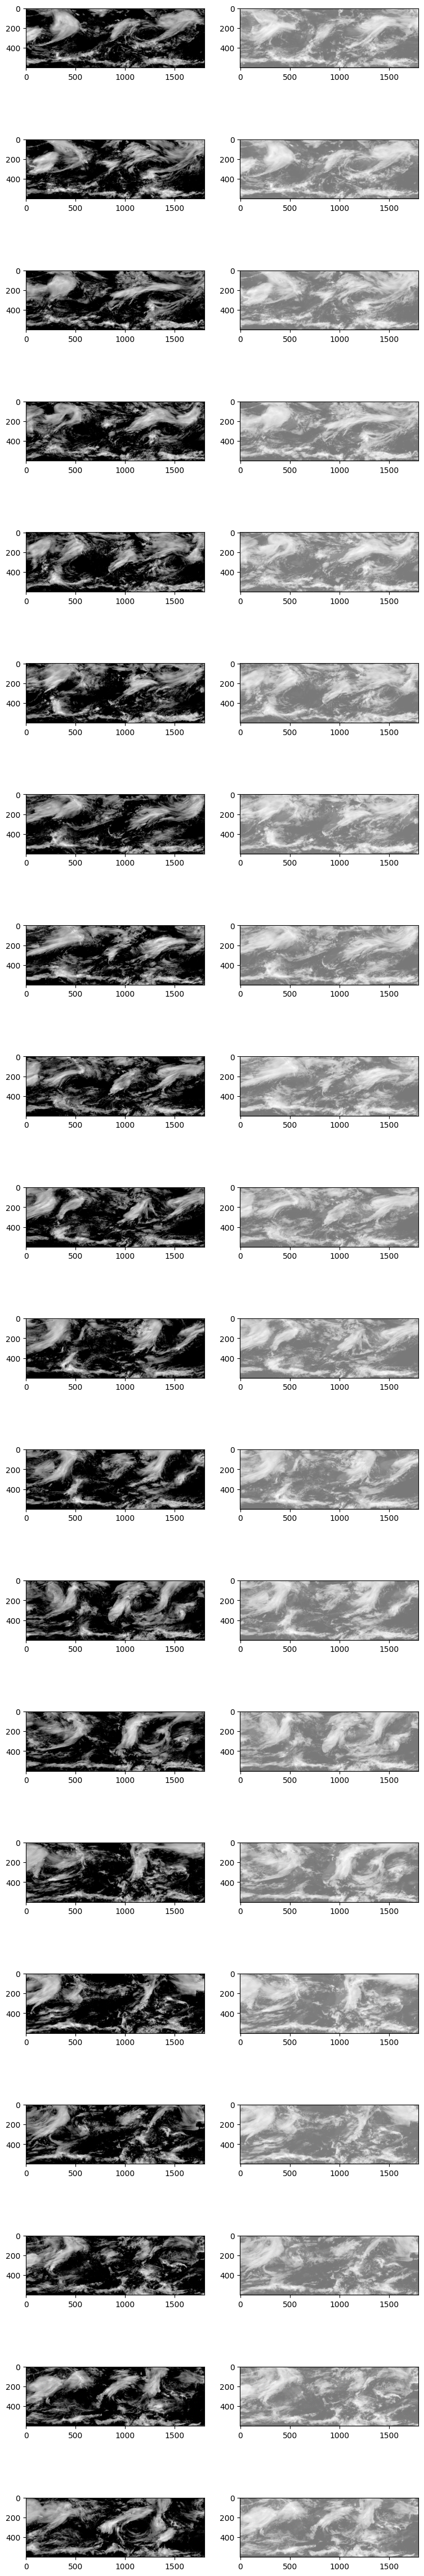

In [10]:
def predict(m, X_test):
    """ Assuming batch_size = 1 """
    
    hidden = m.init_hidden(batch_size, imgs.shape[-2:])
    
    for step in range(seq_len - 1 - 1):
        _, hidden = model(X_test[:,step], hidden)

    pred, _ = model(X_test[:, -1], hidden)
    return pred.detach().numpy().reshape(*(imgs.shape[-2:]))

n_days = 20
cols = 2
fig, axs = plt.subplots(n_days, cols, figsize=(9, 3*n_days))

model.eval()

for i in range(n_days):

    # Get predicted
    X = np.array([
                    imgs[
                            len(train) - (seq_len - 1) + i:
                            len(train) + i
                            ].reshape(seq_len - 1, 1, *(imgs.shape[-2:])) # Explicit single gs channel
                            for seq_n in range(batch_size)
                ])
    y = imgs[len(train) + i]
    y_pred = predict(model, torch.from_numpy(X))

    # Plot real
    plt.subplot(n_days, cols, i * cols + 1)
    plt.imshow(y, cmap='gray')

    # Plot predicted
    plt.subplot(n_days, cols, i * cols + 2)
    plt.imshow(y_pred, cmap='gray')